**This project is about taking what I learned in the "one author from title" notebook and applying it to the entire dataset, using the entire body of the text instead of just the title. I will still be using scikit-learn's TfidfVectorizer as my plaintext vectorizer in this project.**

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

First I read in the papers_and_authors csv.

In [2]:
papers_and_authors = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/papers_and_authors.csv')
papers_and_authors.head()

,year,title,event_type,pdf_name,abstract,paper_text,paper_id,author_id
0,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1
1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54


Now, I am only dropping the pdf_name and abstract fields. The pdf name is redundant/useless information and the abstract field is incomplete and I'm not yet sure how to deal with it in the final analysis.

In [3]:
auth_text_len = papers_and_authors.drop(['pdf_name', 'abstract'], axis=1)
auth_text_len.head()

,year,title,event_type,paper_text,paper_id,author_id
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54


I want to add some additional features to my dataset, and the first one will be the length of the title. The first line checks the length of the title at position 0, the using .apply I create a new column with the title lengths as the values. Double checking the head confirms that my first title is 62 characters long.

In [4]:
print(len(auth_text_len.at[0, 'title']))

auth_text_len['title_len'] = auth_text_len.title.apply(lambda row: len(row))
auth_text_len.head()

62


,year,title,event_type,paper_text,paper_id,author_id,title_len
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116


The next step is doing this with total paper length. It's possible that word count would be better than character count, but for now I'll use this.

In [5]:
auth_text_len['paper_len'] = auth_text_len.paper_text.apply(lambda row: len(row))
auth_text_len.head()

,year,title,event_type,paper_text,paper_id,author_id,title_len,paper_len
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523


I also want a feature for average word length in the paper, below is a custom function that splits the body of the text into the individual words, then finds their average length. It takes a block of text, in this case the values from the paper_text column, as its only parameter.

Checking that this works on the first row of the data.

In [6]:
def avg_word_len(row):
    text_list = row.split()
    try:
        avg_len = sum(len(word) for word in text_list) / len(text_list)
        return avg_len
    except:
        return 0

In [7]:
avg_word_len(auth_text_len.paper_text[0])

4.8082635700783145

Now I'm applying this function across the entire dataset with lambda, and double checking that it correctly created a new column.

In [8]:
auth_text_len['avg_word_len'] = auth_text_len.paper_text.apply(lambda row: avg_word_len(row))
auth_text_len.head()

,year,title,event_type,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861


I had 4 entries that had an average word length of 0. I drop them and double check that none remain.

In [9]:
print(auth_text_len.query('avg_word_len == 0'))

auth_text_len.drop(auth_text_len[auth_text_len['avg_word_len']==0].index, inplace=True)

print(auth_text_len.query('avg_word_len == 0'))

       year                                              title event_type  \
15924  2016  Regret Bounds for Non-decomposable Metrics wit...     Poster   
15925  2016  Regret Bounds for Non-decomposable Metrics wit...     Poster   
18546  2017  Mean Field Residual Networks: On the Edge of C...     Poster   
18547  2017  Mean Field Residual Networks: On the Edge of C...     Poster   

      paper_text  paper_id  author_id  title_len  paper_len  avg_word_len  
15924        6178       6597         62          9           0.0  
15925        6178       3906         62          9           0.0  
18546        6879       9809         50          9           0.0  
18547        6879      10122         50          9           0.0  
Empty DataFrame
Columns: [year, title, event_type, paper_text, paper_id, author_id, title_len, paper_len, avg_word_len]
Index: []


Now I fill the Nan's in the event_type column with Unknown, and drop the title column, as I only want text from the body of the paper right now. 

In [10]:
added_features = auth_text_len.fillna('Unknown')
added_features.drop(['title'], axis=1, inplace=True)
added_features.head()

,year,event_type,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len
0,1987,Unknown,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264
1,1987,Unknown,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264
2,1987,Unknown,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807
3,1988,Unknown,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861
4,1988,Unknown,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861


I use .get_dummies to change the categorical data from the event_type column to sparse numeric data, then join it to my dataframe and drop the old event_type column.

In [11]:
dummies = pd.get_dummies(added_features.event_type)
dummies.head()
added_dummies = added_features.join(dummies, how='outer')
added_dummies.drop(['event_type'], axis=1, inplace=True)
added_dummies.head()

,year,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown
0,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264,0,0,0,1
1,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264,0,0,0,1
2,1987,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807,0,0,0,1
3,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861,0,0,0,1
4,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861,0,0,0,1


Saving this dataframe for later

In [12]:
datapath = 'E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/added_features_data.csv'
added_dummies.to_csv(datapath, index=False)

Now I am using a custom function to check for Michael Jordan's author id (330), and return a 1 if he wrote the paper and a 0 if he did not.

In [13]:
def jordan_detector(row):
    if row['author_id'] == 1472:
        return 1
    else:
        return 0

Applying this custom function to the dataframe creates a new column with what will be my target feature, the is_jordan column.

In [14]:
added_dummies['is_jordan'] = added_dummies.apply(lambda row: jordan_detector(row), axis=1)
added_dummies.head()

,year,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_jordan
0,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264,0,0,0,1,0
1,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264,0,0,0,1,0
2,1987,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807,0,0,0,1,0
3,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861,0,0,0,1,0
4,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861,0,0,0,1,0


Now I can drop the author_id column, and in order to remove duplicate papers I sort Jordan's papers to the top and use drop_duplicates with keep='first'. This creates a dataframe with 7239 entries, one for each unique paper. This is two less than the 7241 papers I initially had, because I removed the two papers with no paper text.

In [15]:
df = added_dummies.drop('author_id', axis=1)
df.sort_values(by='is_jordan', ascending=False, inplace=True)
df.drop_duplicates(subset='paper_id', inplace=True, keep='first')
len(df)

7239

As expected, we have 79 entries for is_jordan == 1.

In [16]:
len(df.query('is_jordan == 1'))

62

A look at my final (pre vectorization) dataframe.

In [17]:
df.head()

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_jordan
17276,2016,Consistent Kernel Mean Estimation\nfor Functio...,6545,67,33747,4.488406,0,1,0,0,1
7238,2008,Bayesian Experimental Design of Magnetic\nReso...,3558,68,33280,4.916890,0,0,0,1,1
1216,1998,Kernel peA and De-Noising in Feature Spaces\n\...,1491,43,22127,4.798472,0,0,0,1,1
1441,1998,Semiparametric Support Vector and\nLinear Prog...,1575,61,18571,4.874520,0,0,0,1,1
17038,2016,Minimax Estimation of Maximum Mean Discrepancy...,6483,66,29683,3.954461,0,1,0,0,1


Saving this dataframe so I can use it later

In [18]:
datapath = 'E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/one_author_advanced_data.csv'
df.to_csv(datapath, index=False)

Now I split the features into X: my predictive features (excluding paper_id and is_jordan), and y: the is_jordan column flattened into a 1-D array.

In [19]:
exclude = ['paper_id', 'is_jordan']
X = df[df.columns.difference(exclude)]

y = df['is_jordan'].values.flatten()


Creating my train and test splits, with a train size of 75% and stratified on my target feature.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, train_size=0.75, stratify=y)

Now it's time to TfidfVectorize the paper text. I fit and transform on the train set and only transform the test set. Looking at the shape indicates that I now have 195,720 total features (mostly individual words). **I SHOULD PLAY WITH THE STOP WORDS SOME, THE NUMBER OF WORDS MISSING SEEMS TO VARY CONSIDERABLY WITH RANDOM SPLIT**

In [21]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train.paper_text)
X_test = tfidf.transform(X_test.paper_text)

print(X_train.shape)
print(X_test.shape)

(5429, 196602)
(1810, 196602)


My initial model will again be a logistic regression with class weights of {0:1, 1:99}, so the model is penalized 99x for an incorrect attribution of a Jordan paper. 

In [22]:
pipe1 = make_pipeline(LogisticRegression(random_state=21, class_weight={0:1, 1:99}, C=1))

I fit on the train data and predict on both the train and test data.

In [23]:
pipe1.fit(X_train, y_train)

pipe1_train_pred = pipe1.predict(X_train)
pipe1_test_pred = pipe1.predict(X_test)

This is the accuracy of the model on the train set. **AGAIN THIS IS VERY HIGH, DOES THIS MEAN I'M OVERFITTING?**

In [24]:
accuracy1_train = pipe1.score(X_train, y_train)
auc1_train = roc_auc_score(y_train, pipe1_train_pred)
recall1_train = recall_score(y_train, pipe1_train_pred)
precision1_train = precision_score(y_train, pipe1_train_pred)
print('Train Accuracy:', accuracy1_train)
print('Train AUC:', auc1_train)
print('Train Recall score:', recall1_train)
print('Train Precision score:', precision1_train)

Train Accuracy: 0.9944741204641738
Train AUC: 0.9972134497492106
Train Recall score: 1.0
Train Precision score: 0.6052631578947368


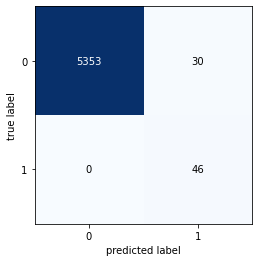

In [25]:
cm1_train = confusion_matrix(y_train, pipe1_train_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm1_train)
plt.show()

Here is the accuracy of the model on the test data, **THIS IS VERY SIMILAR TO WHAT I GOT ON JUST TITLES, THAT DOESN'T SEEM CORRECT**. Although it did get much better at not having false positives (the other model had 43 false positives).

In [26]:
accuracy1_test = pipe1.score(X_test, y_test)
auc1_test = roc_auc_score(y_test, pipe1_test_pred)
recall1_test = recall_score(y_test, pipe1_test_pred)
precision1_test = precision_score(y_test, pipe1_test_pred)
print('Test Accuracy:', accuracy1_test)
print('Test AUC:', auc1_test)
print('Test Recall score:', recall1_test)
print('Train Precision score:', precision1_test)

Test Accuracy: 0.987292817679558
Test AUC: 0.7148481047937569
Test Recall score: 0.4375
Train Precision score: 0.3333333333333333


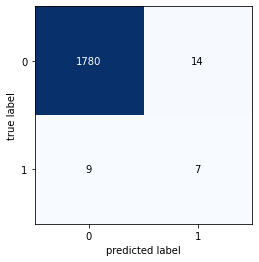

In [27]:
cm1_test = confusion_matrix(y_test, pipe1_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm1_test)
plt.show()

Using GridSearchCV to crossvalidate and find the best value for C to reduce overfitting. I made a new pipeline with no random state for this.

In [28]:
pipe1_rand = make_pipeline(LogisticRegression(class_weight={0:1, 1:99}))

Checking what parameters I have available, right now I'm interested in 'logisticregression__C', as a potential fix for overfitting

In [29]:
pipe1_rand.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'logisticregression', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

The values of C I will test for the model

In [30]:
C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

Creating the grid search, with C as my only parameter I'm checking, and using roc_auc as my score

In [31]:
pipe1_rand_grid_cv = GridSearchCV(pipe1_rand, param_grid={'logisticregression__C':C}, cv=5, n_jobs=-1, scoring='roc_auc')

Fitting the grid search on my X_train and y_train data

In [32]:
pipe1_rand_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 99}))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001]},
             scoring='roc_auc')

The best roc_auc score of the models, lower than the AUC on pipe1 but fairly high still

In [33]:
pipe1_rand_grid_cv.best_score_

0.9104308440115256

In [34]:
pipe1_rand_grid_cv.cv_results_['mean_test_score']

array([0.91043084, 0.90743421, 0.89881264, 0.8943496 , 0.88235895,
       0.87872941, 0.87517002])

A C=1 was chosen **THIS SEEMS STRANGE OR INCORRECT, SEE BELOW**

In [35]:
pipe1_rand_grid_cv.best_params_

{'logisticregression__C': 1}

Picking out the best estimator I found, then predicting on the test set

In [36]:
pipe1_rand_best = pipe1_rand_grid_cv.best_estimator_

In [37]:
pipe1_grid_cv_test_pred = pipe1_rand_best.predict(X_test)

**THESE RESULTS ARE IDENTICAL TO THE FIRST TIME, AND IF I MANUALLY CHOOSE A LOWER C VALUE THEY GET BETTER?** For instance, a C=0.5 gives an AUC of 0.597 on the test set. I know the whole point is to not overfit on the test set, but what's going on here? It's possible my random split of my train and test sets happened to be very "unlucky".

In [38]:
accuracy1_grid_cv_test = pipe1_rand_best.score(X_test, y_test)
auc1_grid_cv_test = roc_auc_score(y_test, pipe1_grid_cv_test_pred)
recall1_grid_cv_test = recall_score(y_test, pipe1_grid_cv_test_pred)
precision1_grid_cv_test = precision_score(y_test, pipe1_grid_cv_test_pred)
print('Test Accuracy:', accuracy1_grid_cv_test)
print('Test AUC:', auc1_grid_cv_test)
print('Test Recall score:', recall1_grid_cv_test)
print('Train Precision score:', precision1_grid_cv_test)

Test Accuracy: 0.987292817679558
Test AUC: 0.7148481047937569
Test Recall score: 0.4375
Train Precision score: 0.3333333333333333


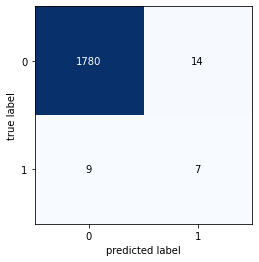

In [39]:
cm1_grid_cv_test = confusion_matrix(y_test, pipe1_grid_cv_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm1_grid_cv_test)
plt.show()